/home/borth/miniconda3/envs/pytorch3d/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.


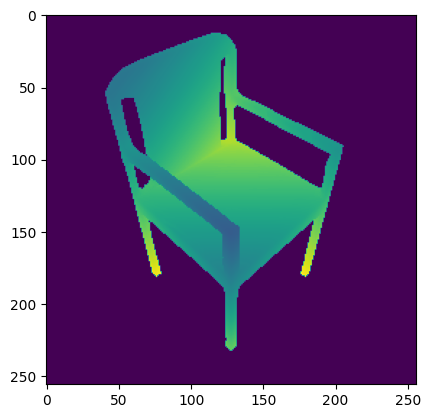

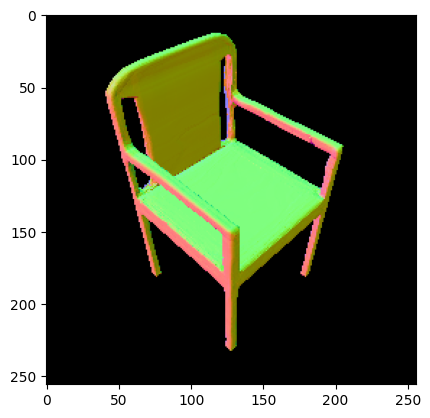

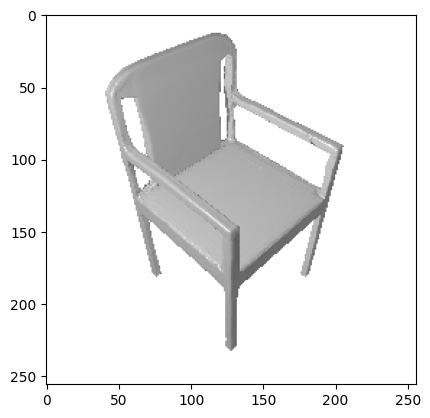

In [5]:
from lib.rendering.utils import visualize_image, visualize_normals
from lib.rendering.renderer import (
    SignedDistanceFunction,
    Camera,
    Light,
    Scene,
    SphereTracer,
    SphereTracerV2,
    SphereTracerV3,
)

ckpt_path = "/home/borth/sketch2shape/logs/save/train_chairs/checkpoints/last.ckpt"
sdf = SignedDistanceFunction(ckpt_path=ckpt_path, obj_idx=34)
camera = Camera(azim=-45, elev=45, resolution=256, dist=1.2)
light = Light(position=[1, 1, 0])
sphere_tracer = SphereTracerV3(max_steps=100, clamp_sdf=0.1, step_scale=1.5)
scene = Scene(sdf=sdf, camera=camera, light=light, sphere_tracer=sphere_tracer)

gt_depth, gt_mask = scene.render_depth()
visualize_image(scene.to_image(gt_depth, gt_mask))

gt_normals, gt_mask = scene.render_normals()
visualize_normals(scene.to_image(gt_normals, gt_mask))

gt_image, gt_mask = scene.render_image()
visualize_image(scene.to_image(gt_image, gt_mask, default=1))

In [33]:
gt_depth = gt_depth.detach()

In [35]:
gt_depth.max()

tensor(1.7471, device='cuda:0')

In [28]:
from tqdm import tqdm
from PIL import Image
from torchvision.transforms import ToTensor
from lib.models.siamese import Siamese

import torch
from torch.nn.functional import normalize
from torch.optim import Adam
import matplotlib.pyplot as plt
from lib.rendering.renderer import (
    SignedDistanceFunction,
    Camera,
    Light,
    Scene,
    SphereTracer,
)

sdf_ckpt_path = "/home/borth/sketch2shape/logs/save/train_chairs/checkpoints/last.ckpt"

sdf = SignedDistanceFunction(ckpt_path=sdf_ckpt_path, obj_idx=34)
sdf.lat_vec = sdf.lat_vec + torch.randn(sdf.lat_vec.shape).to("cuda") * 0.2
scene = Scene(sdf=sdf, camera=camera, light=light, sphere_tracer=sphere_tracer)

sdf.lat_vec.requires_grad = True
optimizer = Adam([sdf.lat_vec], lr=1e-04)

for steps in tqdm(range(20)):
    optimizer.zero_grad()
    target_depth, target_mask = scene.render_depth()
    scene.to_image(target_depth, mask)
    loss = torch.nn.functional.l1_loss(depth, target_depth)
    loss.backward()
    optimizer.step()

    if steps % 2 == 0:
        print(steps, loss)
        # print(sdf.lat_vec[0])
        visualize_normals(scene.to_image(target_depth, mask))

    # loss = sd.sum()
    # loss.backward(retain_graph=True)
    # target_normals = normalize(points.grad)  # type: ignore

/home/borth/miniconda3/envs/pytorch3d/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  0%|          | 0/20 [01:46<?, ?it/s]


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [34]:
from tqdm import tqdm
from PIL import Image
from torchvision.transforms import ToTensor
from lib.models.siamese import Siamese

import torch
from torch.nn.functional import normalize
from torch.optim import Adam
import matplotlib.pyplot as plt
from lib.rendering.renderer import (
    SignedDistanceFunction,
    Camera,
    Light,
    Scene,
    SphereTracer,
)

sdf_ckpt_path = "/home/borth/sketch2shape/logs/save/train_chairs/checkpoints/last.ckpt"

sdf = SignedDistanceFunction(ckpt_path=sdf_ckpt_path, obj_idx=34)
sdf.lat_vec = sdf.lat_vec + torch.randn(sdf.lat_vec.shape).to("cuda") * 0.2
scene = Scene(sdf=sdf, camera=camera, light=light, sphere_tracer=sphere_tracer)

sdf.lat_vec.requires_grad = True
optimizer = Adam([sdf.lat_vec], lr=1e-02)

for steps in tqdm(range(20)):
    optimizer.zero_grad()

    target_points, target_mask, _ = scene.sphere_tracing()
    target_points.requires_grad = True
    mask = target_mask & gt_mask
    sd = sdf.predict(target_points, mask)
    (grad,) = torch.autograd.grad(
        outputs=sd,
        inputs=target_points,
        grad_outputs=torch.ones_like(sd),
        create_graph=True,
    )
    target_normals = normalize(grad)

    _target_normals = target_normals[mask].view(-1, 1, 3)
    _gt_normals = gt_normals[mask].view(-1, 3, 1)
    loss = -torch.bmm(_target_normals, _gt_normals)

    loss.backward(retain_graph=True)
    optimizer.step()

    if steps % 2 == 0:
        print(steps, loss)
        # print(sdf.lat_vec[0])
        visualize_normals(scene.to_image(target_normals, mask))

/home/borth/miniconda3/envs/pytorch3d/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  0%|          | 0/20 [00:17<?, ?it/s]


RuntimeError: grad can be implicitly created only for scalar outputs

In [ ]:
points

In [ ]:
from tqdm import tqdm
from PIL import Image
from torchvision.transforms import ToTensor
from lib.models.siamese import Siamese

import torch
from torch.optim import Adam
import matplotlib.pyplot as plt
from lib.rendering.renderer import (
    SignedDistanceFunction,
    Camera,
    Light,
    Scene,
    SphereTracer,
)

sdf_ckpt_path = "/home/borth/sketch2shape/logs/save/train_chairs/checkpoints/last.ckpt"
siamese_ckpt_path = "/home/borth/sketch2shape/logs/save/siamese/checkpoints/last.ckpt"
sketch_path = "/home/borth/sketch2shape/data/siamese_chair_large/96d9944f46bd330979414e04132a8bef/sketches/00021.jpg"

# siamese = Siamese.load_from_checkpoint(siamese_ckpt_path)
sdf = SignedDistanceFunction(ckpt_path=sdf_ckpt_path, obj_idx=34)
# sdf.lat_vec = sdf.lat_vec + torch.randn(sdf.lat_vec.shape).to("cuda")
camera = Camera(azim=-45, elev=45, resolution=256, dist=1.2)
light = Light(position=[1, 1, 0])
scene = Scene(sdf=sdf, camera=camera, light=light)

optimizer = Adam(sdf.model.parameters(), lr=1e-04)
normals.requires_grad = True

for steps in tqdm(range(100)):
    # image_emb = siamese.decoder(image[None])
    # normalized_image_emb = torch.nn.functional.normalize(image_emb)
    # loss = (sketch_emb @ image_emb.T).sum()
    target_normals, mask = scene.render_normals()

    loss = torch.norm(target_normals[mask] - normals[mask])
    loss.backward(retain_graph=True)

    if steps % 10 == 0:
        print(steps, loss)
        visualize_normals(target_normals)

    loss.backward(retain_graph=True)
    optimizer.step()
    optimizer.zero_grad()

In [ ]:
from lib.utils import load_config
from lightning import Trainer
from lib.eval.tester import SiameseTester
import hydra

cfg = load_config("eval_siamese", overrides=["+experiment=eval"])
tester = SiameseTester(model=siamese.decoder)
datamodule = hydra.utils.instantiate(cfg.data, train=False)
datamodule.setup("all")
trainer = Trainer(
    accelerator="gpu",
    max_epochs=1,
    enable_checkpointing=False,
)
trainer.validate(
    tester,
    dataloaders=[
        datamodule.train_dataloader(),
        datamodule.val_dataloader(),
    ],
)